# user2code2vec

Profiling users based on their code submissions

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
font = {'weight': 'bold', 'size': 10}
plt.rc('font', **font)

In [3]:
MAX_LENGTH = 50

## Data

In [4]:
df_programs = pd.read_json('data/raw/programming_data.json')

In [5]:
df_programs.head(2)

,academic_year_0,academic_year_1,correct,date,extension,ip,module,task,upload,user
0,2016,2017,True,2016-09-19 14:11:41,py,,ca277,add.py,#!/usr/bin/env python\n\na = int(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c
1,2016,2017,True,2016-09-19 14:17:33,py,,ca277,concat-lines.py,#!/usr/bin/env python\n\na = str(raw_input())\...,b9e7e608-6036-4d44-8770-a7036176b53c


In [6]:
'{:,}'.format(len(df_programs))

'591,707'

In [7]:
df_grades = pd.read_json('data/raw/grades_data.json')

In [8]:
df_grades.head(2)

,academic_year_0,academic_year_1,exam_week,grade,module,user
0,2015,2016,12,40,ca114,e45f938b-9d5c-4838-86ce-0755e3c97053
1,2015,2016,12,60,ca114,91b06877-f0e0-4af9-bbd4-b20ffa90e36b


In [9]:
len(df_grades.user.unique())

666

## Tokenizers

**Words**

In [10]:
import pickle

with open('data/processed/word_tokenizer.pickle', 'rb') as handle:
    word_tokenizer = pickle.load(handle)

Using TensorFlow backend.


In [11]:
word_tokenizer

In [12]:
#word_embeddings = np.load('data/processed/word_embeddings.npy')

In [13]:
#word_embeddings[0]

In [14]:
#'{:,}'.format(len(word_embeddings))

In [15]:
# Dictionary of words
id_to_word = { v: k for k, v in word_tokenizer.word_index.items() }

In [16]:
[id_to_word[i] for i in range(1, 6)]   

[u'=', u'i', u'+', u'if', u'def']

In [17]:
'{:,}'.format(len(id_to_word))

'231,658'

In [18]:
# Top words
[word for word, occurrences in sorted(word_tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:5]]

[u'=', u'i', u'+', u'if', u'def']

**Token**

In [19]:
with open('data/processed/token_tokenizer.pickle', 'rb') as handle:
    token_tokenizer = pickle.load(handle)

In [20]:
token_tokenizer

In [21]:
#token_embeddings = np.load('data/processed/token_embeddings.npy')

In [22]:
#token_embeddings[0]

In [23]:
#len(token_embeddings[0])

In [24]:
#'{:,}'.format(len(token_embeddings))

In [25]:
id_to_token = { v: k for k, v in token_tokenizer.word_index.items() }

In [26]:
id_to_token[1]

u')'

In [27]:
'{:,}'.format(len(id_to_token))

'37,912'

In [28]:
# Top token words
[word for word, occurrences in sorted(token_tokenizer.word_counts.items(), key=lambda t: t[1], reverse=True)[:5]]

[u')', u'(', u'=', u':', u'.']

**Categories**

In [29]:
with open('data/processed/category_tokenizer.pickle', 'rb') as handle:
    category_tokenizer = pickle.load(handle)

## CA116 on 2016/2017

In [143]:
course = 'ca116'
academic_year = [2016, 2017]

In [144]:
def get_data(course, academic_year):

    programs = df_programs[(df_programs['module'] == course) &
                           (df_programs['academic_year_0'] == academic_year[0])]
    
    exercises = sorted(programs.task.unique())
    
    grades = df_grades[(df_grades['module'] == course) &
                       (df_grades['academic_year_0'] == academic_year[0])]
    
    students = grades.user.unique()
    
    return programs, exercises, grades, students

In [145]:
programs_cs1, exercises_cs1, grades_cs1, students_cs1 = get_data(course, academic_year)

In [146]:
'# Programs: {:,}'.format(len(programs_cs1)), '# Exercises', len(exercises_cs1), '# Grades: {:,}'.format(len(grades_cs1)), '# Students', len(students_cs1)

('# Programs: 68,313', '# Exercises', 276, '# Grades: 327', '# Students', 126)

In [147]:
import re
def remove_comments(text):
    return re.sub(re.compile('#.*?\n'), '', text)

In [148]:
from keras.preprocessing.sequence import pad_sequences

In [149]:
def get_vectors(tokenizer, programs, exercises, grades, students, program='latest'):
    
    usr_matrix = {}
    avg_grade = {}

    for student_name in students:
        
        # Grade
        average = grades[grades['user'] == student_name]['grade'].mean()    
        avg_grade[student_name] = average
        
        for task in exercises:
    
            # Code programs
            submissions = programs[(programs['user'] == student_name) & 
                                   (programs['task'] == task)].sort_values(by='date', ascending=False).index
            
            if len(submissions) > 0: 
            
                if program == 'latest': # latest submission
                    latest_index = submissions[0]
                    submission = df_programs.iloc[latest_index, :]['upload']
                else: # random
                    random_index = random.choice(submissions)
                    submission = df_programs.iloc[random_index, :]['upload']

                submission = remove_comments(submission)

                # Sequences
                sequences = tokenizer.texts_to_sequences([submission])
                # Padded sequences
                padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post')

                sequence = padded_sequences[0]
                
            else:
                
                sequence = np.zeros(MAX_LENGTH)
            
            usr_matrix.setdefault(student_name, [])
            usr_matrix[student_name].append(sequence)
    
    return usr_matrix, avg_grade

**Words & Latest submission**

In [150]:
# latest
word_usr_matrix, word_avg_grade = get_vectors(word_tokenizer, programs_cs1, exercises_cs1, grades_cs1, students_cs1)

In [38]:
len(word_usr_matrix), len(word_avg_grade)

(126, 126)

In [39]:
sample_user = '2157ade0-6890-435b-8669-a884e3233bc7'

In [40]:
'# Tasks:', len(word_usr_matrix[sample_user]), len(exercises)

('# Tasks:', 276, 276)

In [41]:
'Len each vector:', word_usr_matrix[sample_user][0].shape, MAX_LENGTH

('Len each vector:', (50,), 50)

In [42]:
np.array(word_usr_matrix[sample_user])

array([[ 21.,  27.,  64., ...,  26.,   3.,  11.],
       [ 17.,   1.,  34., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ..., 
       [ 16.,  19.,   1., ...,   0.,   0.,   0.],
       [ 16.,  19.,  20., ...,   0.,   0.,   0.],
       [ 16.,  19.,   1., ...,   0.,   0.,   0.]])

Flatten the matrix:

In [43]:
np.array(word_usr_matrix[sample_user]).flatten()

array([ 21.,  27.,  64., ...,   0.,   0.,   0.])

In [45]:
np.array(word_usr_matrix[sample_user]).flatten().shape

(13800,)

In [46]:
word_avg_grade[sample_user]

58.0

In [47]:
def get_long_vectors(list_students, usr_matrix, usr_grades):
    
    long_vectors = []
    ord_grades = []
    
    for student_identifier in sorted(list_students):
        
        long_vector = np.array(usr_matrix[student_identifier]).flatten()
        long_vectors.append(long_vector)
        
        ord_grades.append(usr_grades[student_identifier])
    
    return np.array(long_vectors), np.array(ord_grades)

Get long flat vectors with all the submissions:

In [48]:
word_long_vectors_cs1, word_grades_cs1 = get_long_vectors(students_cs1, word_usr_matrix, word_avg_grade)

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [50]:
NUM_STUDENTS = len(students_cs1)

In [51]:
NUM_STUDENTS

126

In [52]:
INPUT_LENGTH = len(exercises_cs1) * MAX_LENGTH

In [53]:
INPUT_LENGTH

13800

In [54]:
# Classification: Pass vs Fail
THRESHOLD = 40
word_grades_PF_cs1 = word_grades_cs1 < THRESHOLD

In [55]:
word_grades_PF_cs1

array([False, False, False,  True, False, False,  True, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False,  True, False,  True, False,  True, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
        True, False, False, False, False,  True, False,  True, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
        True, False,  True,  True, False, False,  True,  True,  True], dtype=bool)

In [59]:
len(word_grades_PF_cs1)

126

In [60]:
len(word_long_vectors_cs1)

126

In [64]:
NUM_WORDS = 2000

In [65]:
word_long_vectors_normalized_cs1 = word_long_vectors_cs1 / NUM_WORDS 

In [66]:
word_long_vectors_normalized_cs1.shape

(126, 13800)

In [112]:
def get_model(NUM_STUDENTS, INPUT_LENGTH):

    # define the model
    model = Sequential()
    model.add(Embedding(NUM_STUDENTS, 100, input_length=INPUT_LENGTH))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    # summarize the model
    print(model.summary())
    return model

In [82]:
model_cs1 = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 13800, 100)        12600     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1380000)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1380001   
Total params: 1,392,601
Trainable params: 1,392,601
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
# fit
model_cs1.fit(word_long_vectors_normalized_cs1, 
              word_grades_PF_cs1,
              batch_size=10,
              epochs=10,
              validation_split=0.1)

Train on 113 samples, validate on 13 samples
Epoch 1/10
113/113 [==============================] - 2s 14ms/step - loss: 3.6277 - acc: 0.7080 - val_loss: 11.1587 - val_acc: 0.3077
Epoch 2/10
113/113 [==============================] - 1s 9ms/step - loss: 3.8512 - acc: 0.7611 - val_loss: 11.1587 - val_acc: 0.3077
Epoch 3/10
113/113 [==============================] - 1s 9ms/step - loss: 3.8512 - acc: 0.7611 - val_loss: 11.1587 - val_acc: 0.3077
Epoch 4/10
113/113 [==============================] - 1s 8ms/step - loss: 3.8512 - acc: 0.7611 - val_loss: 11.1587 - val_acc: 0.3077
Epoch 5/10
113/113 [==============================] - 1s 9ms/step - loss: 3.8512 - acc: 0.7611 - val_loss: 11.1587 - val_acc: 0.3077
Epoch 6/10
113/113 [==============================] - 1s 9ms/step - loss: 3.8512 - acc: 0.7611 - val_loss: 11.1587 - val_acc: 0.3077
Epoch 7/10
113/113 [==============================] - 1s 9ms/step - loss: 3.8512 - acc: 0.7611 - val_loss: 11.1587 - val_acc: 0.3077
Epoch 8/10
113/113 [===

In [84]:
def get_embeddings(model):

    # Embedding Layer
    embedding_layer = model.layers[0]
    embeddings = embedding_layer.get_weights()[0]
    print 'Embedding Layer shape:', embeddings.shape
    
    return embeddings

In [85]:
word_embeddings_cs1 = get_embeddings(model_cs1)

Embedding Layer shape: (126, 100)


In [86]:
word_embeddings_cs1[0]

array([-0.01625017, -0.05315671,  0.023313  , -0.03459588,  0.03326927,
        0.04000146,  0.04902682,  0.00899275,  0.03961425, -0.05524522,
        0.04369005, -0.05444517, -0.03817959, -0.02768388,  0.01397563,
        0.04324307,  0.05206598, -0.01513672,  0.04229155,  0.05132439,
        0.05025043,  0.00829243,  0.0468758 , -0.01221561,  0.01230095,
        0.01533404,  0.02805373,  0.04991719,  0.02804281, -0.0161137 ,
       -0.02582516, -0.01441804, -0.04421   ,  0.05010355,  0.00983164,
        0.04159693, -0.02698925,  0.02391216, -0.01038359, -0.00990992,
        0.03479475, -0.02873434, -0.03761004, -0.01167469, -0.01358406,
        0.05334106, -0.02443621,  0.04959005,  0.02640499,  0.04182405,
       -0.02270862, -0.02598502,  0.04899558, -0.02579589,  0.05423144,
        0.03163172, -0.05116317, -0.0309667 , -0.05451898, -0.02581248,
       -0.03078377, -0.02183701, -0.05116829, -0.01076464, -0.03128011,
       -0.01019508, -0.00759506, -0.03255185, -0.03212566,  0.02

In [87]:
from sklearn.decomposition import PCA

def get_pca(vectors):

    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(vectors)
    print 'PCA explained variance ratio:', pca.explained_variance_ratio_, 'Total:', sum(pca.explained_variance_ratio_)
    return principal_components

In [88]:
embeddings_pca_cs1 = get_pca(word_embeddings_cs1)

PCA explained variance ratio: [ 0.03403775  0.03286329] Total: 0.0669010430574


In [140]:
def get_5_colors(grade):
    
    if grade < 20:
        return 'black'
    elif grade < 40:
        return 'brown'
    elif grade < 60:
        return 'lightblue'
    elif grade < 80:
        return 'cyan'
    else:
        return 'blue'

In [90]:
def get_2_colors(grade):
    
    if grade < 40:
        return 'red'
    else:
        return 'green'

In [179]:
from matplotlib.lines import Line2D

def plot_vectors(low_dim_vectors, grades, c='two', figsize=(8, 8)):

    if c == 'two':
        function = get_2_colors
    else:
        function = get_5_colors
    
    plt.figure(figsize=figsize, dpi=100)
    ax = plt.axes()
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    
    i = 0
    while i < len(low_dim_vectors):
            
        x, y = low_dim_vectors[i, :]
        g = grades[i]
        color = function(g)
        plt.scatter(x, y, color=color)
        
        i += 1
        
    legend_colors = [
        ('[0, 20)', 'black'),
        ('[20, 40)', 'brown'),
        ('[40, 60)', 'lightblue'),
        ('[60, 80)', 'cyan'),
        ('[80, 100]', 'blue'),
    ]
    legend_elements = []
    for l in legend_colors:
        label, color = l
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10)
        )
    ax.legend(handles=legend_elements, loc='upper right')

In [166]:
plot_vectors(embeddings_pca_cs1, word_grades_cs1, c='five')

NameError: name 'embeddings_pca_cs1' is not defined

In [93]:
word_pca_cs1 = get_pca(word_long_vectors_cs1)

PCA explained variance ratio: [ 0.08898022  0.03134991] Total: 0.120330126708


In [151]:
plot_vectors(word_pca_cs1, word_grades, c='five')

NameError: name 'word_pca_cs1' is not defined

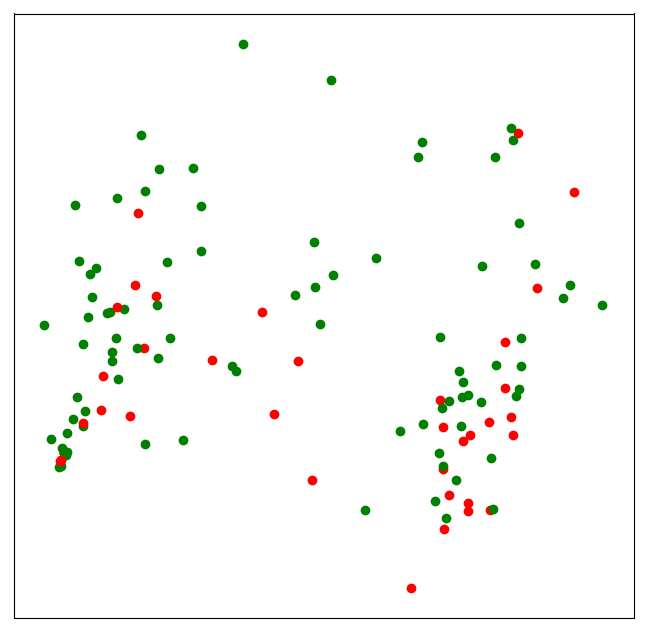

In [95]:
plot_vectors(word_pca, word_grades)

**Words & Random submission**

In [67]:
word_random_usr_matrix, word_random_avg_grade = get_vectors(word_tokenizer, 
                                                            word_embeddings, 
                                                            programs,
                                                            exercises, 
                                                            grades, 
                                                            students,
                                                            program='random')

In [76]:
word_random_long_vectors, word_random_grades = get_long_vectors(students, word_usr_matrix, word_avg_grade)

In [77]:
word_random_pca = get_pca(word_random_long_vectors)

PCA explained variance ratio: [ 0.08898022  0.03135038] Total: 0.120330595932


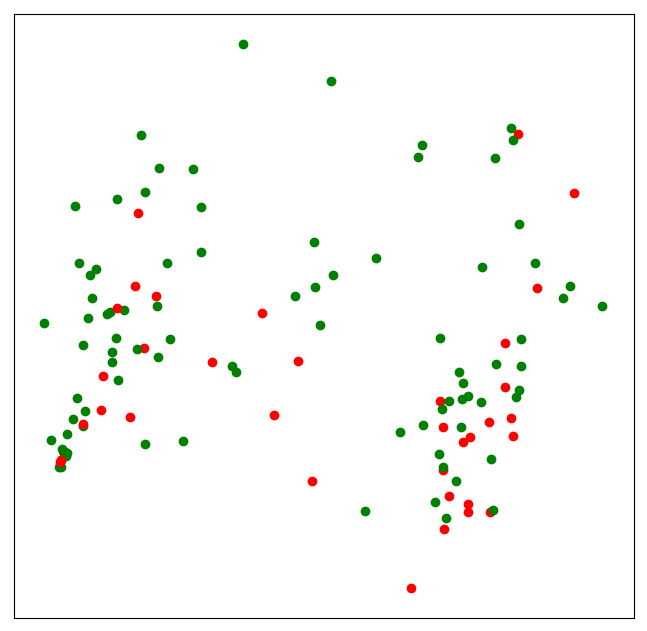

In [78]:
plot_vectors(word_random_pca, word_random_grades)

**Tokens & Latest Submission**

In [152]:
token_usr_matrix, token_avg_grade = get_vectors(token_tokenizer, programs, exercises, grades, students)

In [153]:
token_long_vectors, token_grades = get_long_vectors(students, token_usr_matrix, token_avg_grade)

In [154]:
token_pca = get_pca(token_long_vectors)

PCA explained variance ratio: [ 0.06285195  0.03280906] Total: 0.0956610085063


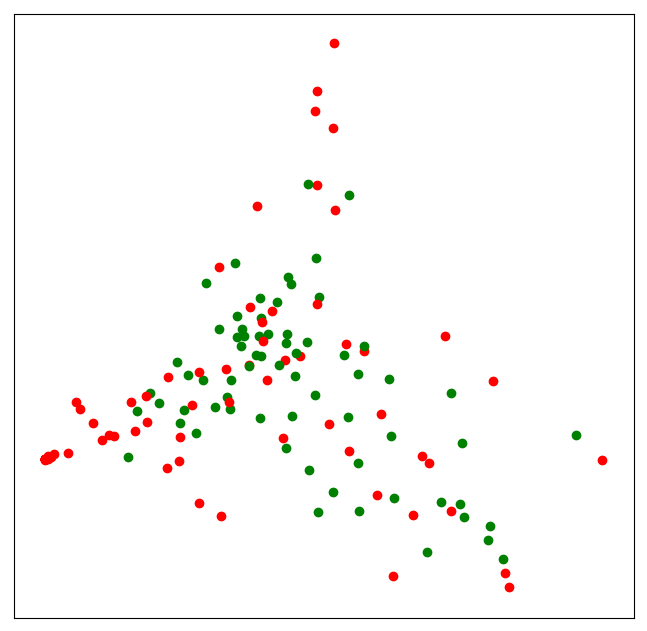

In [155]:
plot_vectors(token_pca, token_grades)

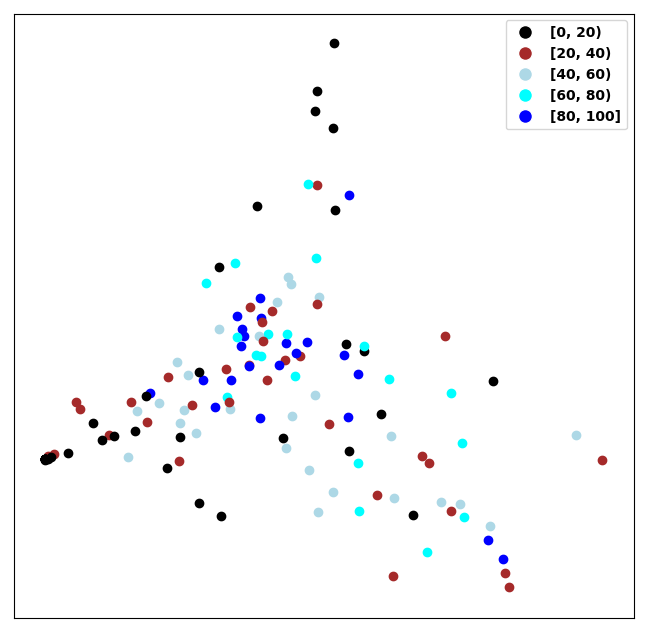

In [180]:
plot_vectors(token_pca, token_grades, c='five')

In [157]:
token_long_vectors_normalized = token_long_vectors / NUM_WORDS

In [158]:
token_grades_PF = token_grades < THRESHOLD

In [159]:
NUM_STUDENTS = len(students)

INPUT_LENGTH = len(exercises) * MAX_LENGTH

NUM_STUDENTS, INPUT_LENGTH

(140, 6600)

In [160]:
token_model = get_model(NUM_STUDENTS, INPUT_LENGTH)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 6600, 100)         14000     
_________________________________________________________________
flatten_7 (Flatten)          (None, 660000)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 660001    
Total params: 674,001
Trainable params: 674,001
Non-trainable params: 0
_________________________________________________________________
None


In [161]:
# fit
token_model.fit(token_long_vectors_normalized, 
                token_grades_PF,
                batch_size=10,
                epochs=10,
                validation_split=0.1)

Train on 126 samples, validate on 14 samples
Epoch 1/10
126/126 [==============================] - 1s 9ms/step - loss: 7.6467 - acc: 0.4841 - val_loss: 3.4162 - val_acc: 0.7857
Epoch 2/10
126/126 [==============================] - 1s 5ms/step - loss: 8.2242 - acc: 0.4841 - val_loss: 3.4162 - val_acc: 0.7857
Epoch 3/10
126/126 [==============================] - 1s 4ms/step - loss: 8.2242 - acc: 0.4841 - val_loss: 3.4162 - val_acc: 0.7857
Epoch 4/10
126/126 [==============================] - 1s 4ms/step - loss: 8.2242 - acc: 0.4841 - val_loss: 3.4162 - val_acc: 0.7857
Epoch 5/10
126/126 [==============================] - 1s 4ms/step - loss: 8.2242 - acc: 0.4841 - val_loss: 3.4162 - val_acc: 0.7857
Epoch 6/10
126/126 [==============================] - 1s 4ms/step - loss: 8.2242 - acc: 0.4841 - val_loss: 3.4162 - val_acc: 0.7857
Epoch 7/10
126/126 [==============================] - 1s 4ms/step - loss: 8.2242 - acc: 0.4841 - val_loss: 3.4162 - val_acc: 0.7857
Epoch 8/10
126/126 [===========

In [162]:
token_embeddings = get_embeddings(token_model)

Embedding Layer shape: (140, 100)


In [163]:
token_embeddings_pca = get_pca(token_embeddings)

PCA explained variance ratio: [ 0.03165596  0.02978322] Total: 0.0614391751587


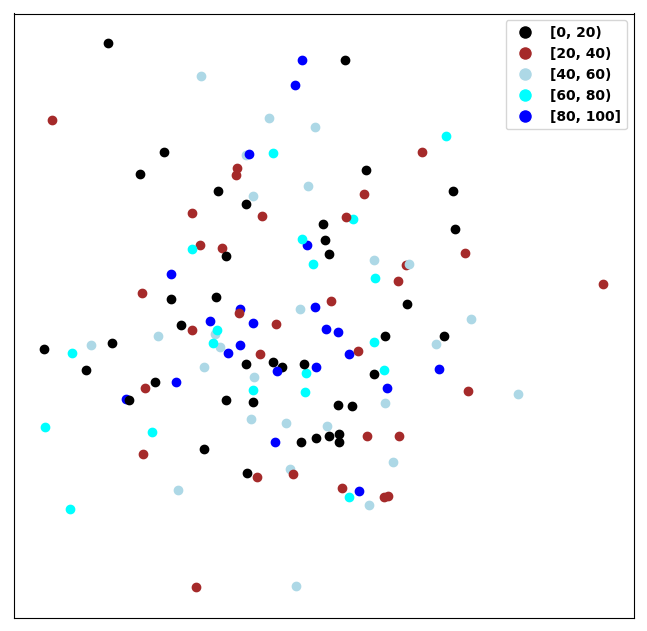

In [181]:
plot_vectors(token_embeddings_pca, token_grades, c='five')

## CA117 on 2016/2017

In [142]:
course = 'ca117'
academic_year = [2016, 2017]

In [97]:
programs, exercises, grades, students = get_data(course, academic_year)

In [98]:
'# Programs: {:,}'.format(len(programs)), '# Exercises', len(exercises), '# Grades: {:,}'.format(len(grades)), '# Students', len(students)

('# Programs: 74,065', '# Exercises', 132, '# Grades: 280', '# Students', 140)

**Words**

In [100]:
word_usr_matrix, word_avg_grade = get_vectors(word_tokenizer, programs, exercises, grades, students)

In [101]:
word_long_vectors, word_grades = get_long_vectors(students, word_usr_matrix, word_avg_grade)

In [102]:
word_pca = get_pca(word_long_vectors)

PCA explained variance ratio: [ 0.10731454  0.03777044] Total: 0.145084981326


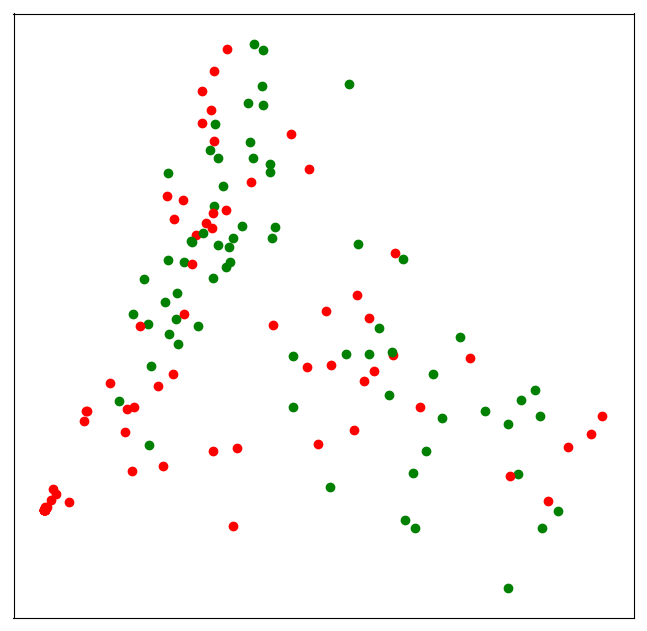

In [103]:
plot_vectors(word_pca, word_grades)

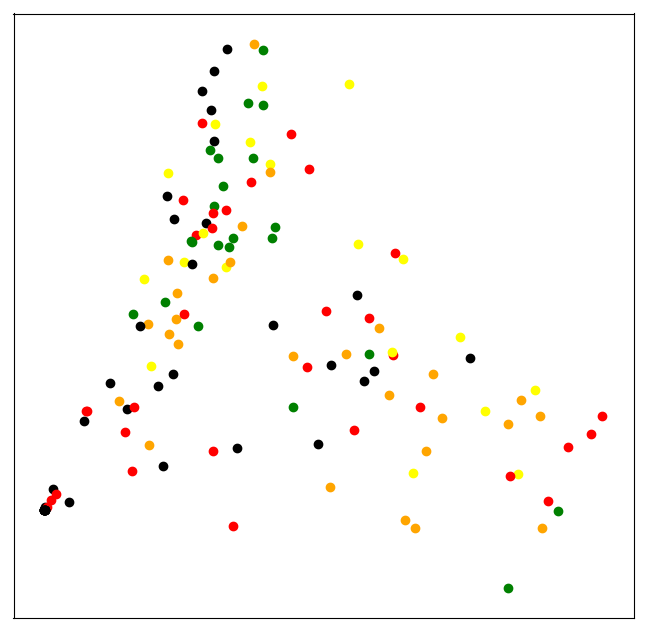

In [104]:
plot_vectors(word_pca, word_grades, c='five')

In [105]:
word_long_vectors_normalized = word_long_vectors / NUM_WORDS 

In [106]:
word_grades_PF = word_grades < THRESHOLD

In [109]:
NUM_STUDENTS = len(students)

In [110]:
INPUT_LENGTH = len(exercises) * MAX_LENGTH

In [111]:
NUM_STUDENTS, INPUT_LENGTH

(140, 6600)

In [113]:
model = get_model(NUM_STUDENTS, INPUT_LENGTH)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 6600, 100)         14000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 660000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 660001    
Total params: 674,001
Trainable params: 674,001
Non-trainable params: 0
_________________________________________________________________
None


In [114]:
model.fit(word_long_vectors_normalized, 
          word_grades_PF,
          batch_size=10,
          epochs=10,
          validation_split=0.1)

Train on 126 samples, validate on 14 samples
Epoch 1/10
126/126 [==============================] - 1s 12ms/step - loss: 7.4743 - acc: 0.5159 - val_loss: 12.6642 - val_acc: 0.2143
Epoch 2/10
126/126 [==============================] - 1s 4ms/step - loss: 7.8032 - acc: 0.5159 - val_loss: 12.6642 - val_acc: 0.2143
Epoch 3/10
126/126 [==============================] - 0s 4ms/step - loss: 7.8032 - acc: 0.5159 - val_loss: 12.6642 - val_acc: 0.2143
Epoch 4/10
126/126 [==============================] - 0s 4ms/step - loss: 7.8032 - acc: 0.5159 - val_loss: 12.6642 - val_acc: 0.2143
Epoch 5/10
126/126 [==============================] - 0s 4ms/step - loss: 7.8032 - acc: 0.5159 - val_loss: 12.6642 - val_acc: 0.2143
Epoch 6/10
126/126 [==============================] - 0s 4ms/step - loss: 7.8032 - acc: 0.5159 - val_loss: 12.6642 - val_acc: 0.2143
Epoch 7/10
126/126 [==============================] - 0s 4ms/step - loss: 7.8032 - acc: 0.5159 - val_loss: 12.6642 - val_acc: 0.2143
Epoch 8/10
126/126 [===

In [115]:
embeddings = get_embeddings(model)

Embedding Layer shape: (140, 100)


In [116]:
embeddings_pca = get_pca(embeddings)

PCA explained variance ratio: [ 0.0326962   0.03091972] Total: 0.0636159181595


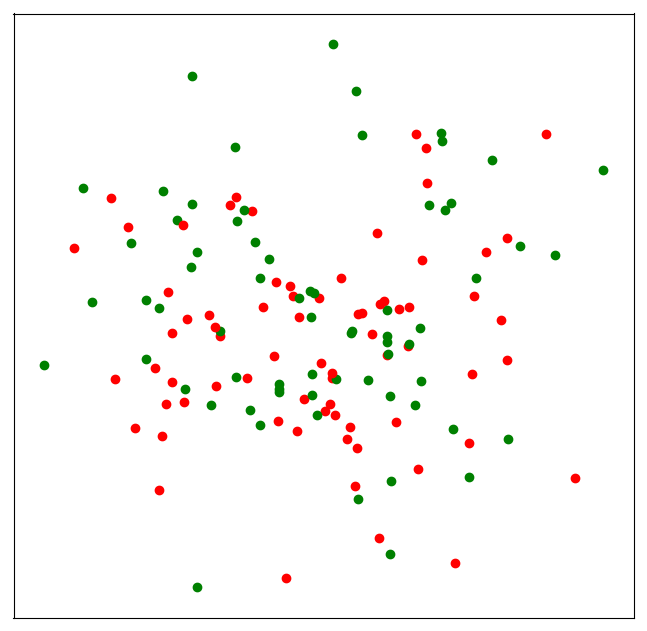

In [117]:
plot_vectors(embeddings_pca, word_grades)

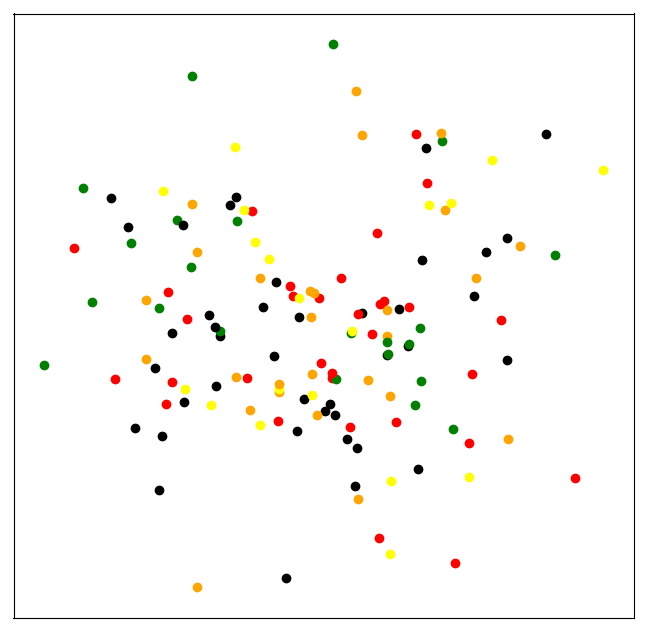

In [118]:
plot_vectors(embeddings_pca, word_grades, c='five')

**Tokens**

In [121]:
token_usr_matrix, token_avg_grade = get_vectors(token_tokenizer, programs, exercises, grades, students)

In [122]:
token_long_vectors, token_grades = get_long_vectors(students, token_usr_matrix, token_avg_grade)

In [123]:
token_pca = get_pca(token_long_vectors)

PCA explained variance ratio: [ 0.06285195  0.03280912] Total: 0.0956610704348


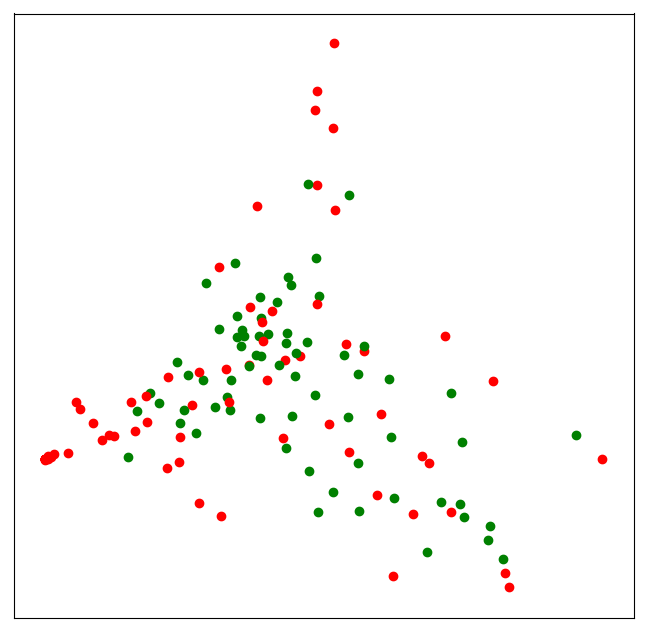

In [124]:
plot_vectors(token_pca, token_grades)

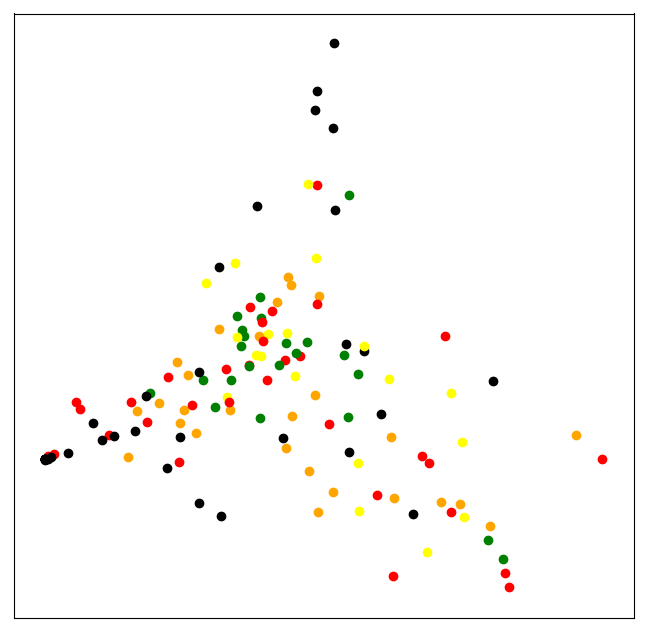

In [125]:
plot_vectors(token_pca, token_grades, c='five')

In [126]:
token_long_vectors_normalized = token_long_vectors / NUM_WORDS 

In [132]:
token_grades_PF = token_grades < THRESHOLD

In [128]:
NUM_STUDENTS = len(students)

In [129]:
INPUT_LENGTH = len(exercises) * MAX_LENGTH

In [130]:
token_model = get_model(NUM_STUDENTS, INPUT_LENGTH)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 6600, 100)         14000     
_________________________________________________________________
flatten_6 (Flatten)          (None, 660000)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 660001    
Total params: 674,001
Trainable params: 674,001
Non-trainable params: 0
_________________________________________________________________
None


In [133]:
token_model.fit(token_long_vectors_normalized, 
                token_grades_PF,
                batch_size=10,
                epochs=10,
                validation_split=0.1)

Train on 126 samples, validate on 14 samples
Epoch 1/10
126/126 [==============================] - 1s 9ms/step - loss: 3.2275 - acc: 0.4841 - val_loss: 1.5679 - val_acc: 0.2143
Epoch 2/10
126/126 [==============================] - 1s 4ms/step - loss: 0.9623 - acc: 0.5000 - val_loss: 0.7904 - val_acc: 0.2143
Epoch 3/10
126/126 [==============================] - 1s 4ms/step - loss: 0.7626 - acc: 0.5000 - val_loss: 0.5694 - val_acc: 0.7857
Epoch 4/10
126/126 [==============================] - 1s 4ms/step - loss: 0.7707 - acc: 0.4524 - val_loss: 1.0265 - val_acc: 0.2143
Epoch 5/10
126/126 [==============================] - 1s 4ms/step - loss: 0.7600 - acc: 0.5317 - val_loss: 0.6261 - val_acc: 0.7857
Epoch 6/10
126/126 [==============================] - 1s 4ms/step - loss: 0.7568 - acc: 0.5317 - val_loss: 0.5816 - val_acc: 0.7857
Epoch 7/10
126/126 [==============================] - 1s 4ms/step - loss: 0.7205 - acc: 0.5000 - val_loss: 0.6680 - val_acc: 0.7857
Epoch 8/10
126/126 [===========

In [134]:
token_embeddings = get_embeddings(token_model)

Embedding Layer shape: (140, 100)


In [135]:
token_embeddings_pca = get_pca(token_embeddings)

PCA explained variance ratio: [ 0.03165487  0.03084413] Total: 0.0624989997596


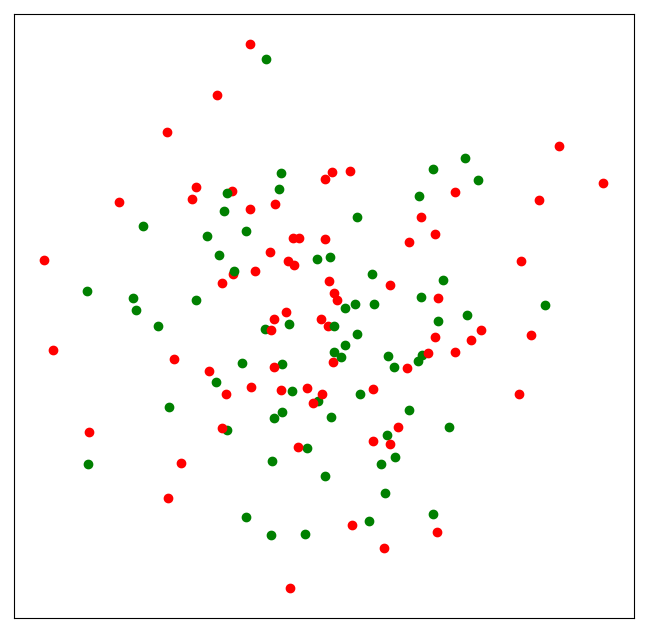

In [136]:
plot_vectors(token_embeddings_pca, token_grades)

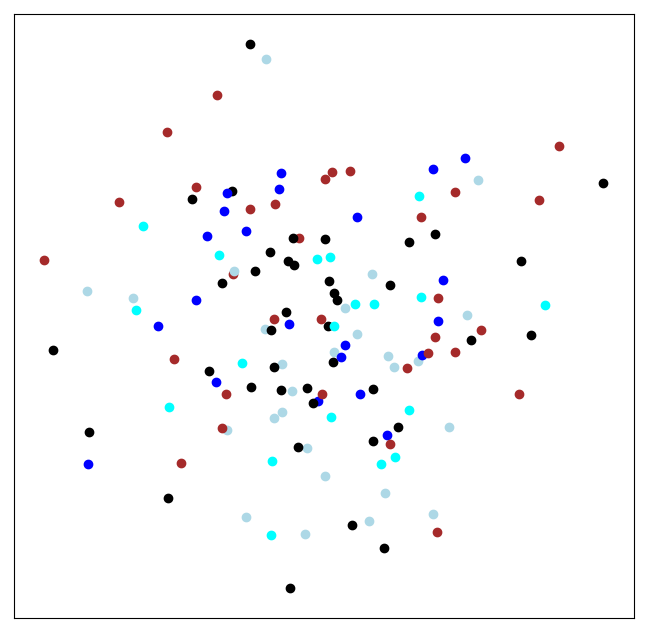

In [141]:
plot_vectors(token_embeddings_pca, token_grades, c='five')